In [1]:
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.8 MB/s eta 0:00:00


# Importing Libraries

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import zipfile
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision import models
from torch.utils.data import random_split
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from torcheval.metrics import MulticlassAUROC,MulticlassF1Score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Downloading Dataset  

In [3]:
# Dowload the dataset
dataset_url = "https://github.com/shrish23/Footprint-Classification/archive/refs/heads/master.zip"
download_url(dataset_url, '.')


with zipfile.ZipFile('./master.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

DATA_DIR = './data/Footprint-Classification-master/Train'
print(os.listdir(DATA_DIR))

dataset = ImageFolder(DATA_DIR)

162759030it [00:05, 30756609.61it/s]


['Leopard', 'Bear', 'Dog', 'elephant', 'Bird', 'Otter', 'Cat', 'boar']


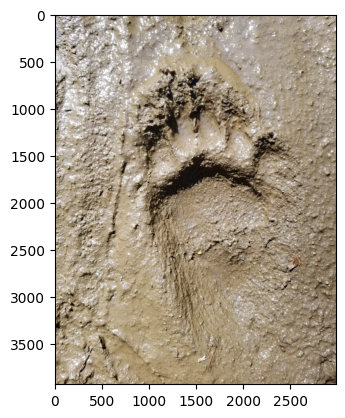

In [4]:
img, label = dataset[0]
plt.imshow(img)

# Data Augmentation

In [5]:
stats = ([0.485, 0.456, 0.406], [0.229,0.224,0.225])
dataset = ImageFolder(DATA_DIR,T.Compose([
    T.Resize(224),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(),
    T.ToTensor(),
    T.Normalize(*stats),
]))

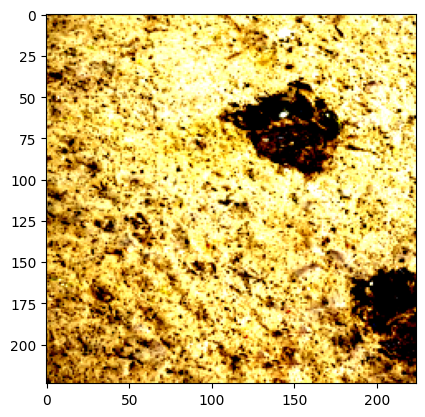

In [6]:
img, label = dataset[5]
plt.imshow(img.permute(1,2,0))

### Denormalize Image

We denormalize the image to visualize the image

In [7]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label: ',dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor,*stats)[0].permute((1,2,0))
    plt.imshow(img_tensor)

Label:  Bear (0)


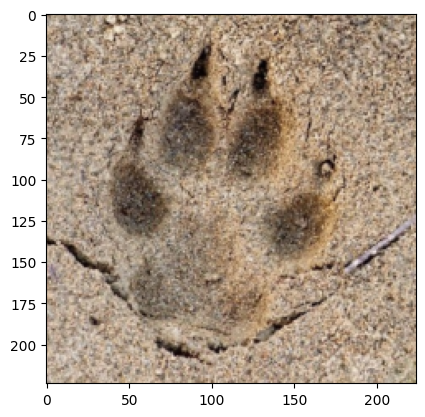

In [8]:
show_image(*dataset[56])

# Creating Training and Validation Sets

In [9]:
val_pct = 0.1
test_pct = 0.2
val_size = int(val_pct * len(dataset))
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset,[train_size,val_size,test_size])
len(train_ds),len(val_ds),len(test_ds)

(1173, 167, 335)

In [10]:
batch_size = 8

train_dl = DataLoader(train_ds, batch_size, shuffle=True,num_workers=4,pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=4,pin_memory=True)

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

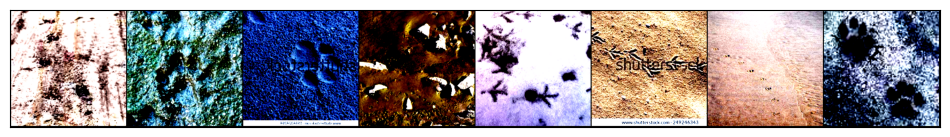

In [12]:
show_batch(train_dl)

# Modifying a Pretrained Model

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Assigning GPU to the data and the model

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

## Finetuning the Pretrained Model

In [17]:
class FootprintsModel(ImageClassificationBase):
    def __init__(self,num_classes,pretrained=True):
        super().__init__()
        self.effeicient_net = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights)
        self.effeicient_net.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=2560,out_features=num_classes,bias=True)
        )

    def forward(self,xb):
        effe = self.effeicient_net(xb)
        out = effe
        return out

## Defining fit_one_cycle and evaluate functions

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()#tells the model that we are evaluating and not training, so dropout is turned off
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                 weight_decay=0,grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    #Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training the model
        model.train()
        train_losses=[]
        lrs=[]
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            #Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            #Record and update the learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        #Validation step
        result = evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Initializing the model

In [19]:
model = to_device(FootprintsModel(len(dataset.classes)),device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:01<00:00, 145MB/s]


## Defining the training Parameters and training the model

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.1109750270843506, 'val_acc': 0.08418367058038712}]

In [21]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam
# These will give 88 % accuracy on the dataset for RESNET152

In [22]:
history += fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,weight_decay,grad_clip)

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00278, train_loss: 1.9033, val_loss: 1.7620, val_acc: 0.3605


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00759, train_loss: 1.3153, val_loss: 1.2223, val_acc: 0.5689


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.01000, train_loss: 0.9430, val_loss: 1.1778, val_acc: 0.6233


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00950, train_loss: 0.6639, val_loss: 0.8772, val_acc: 0.7143


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00812, train_loss: 0.5846, val_loss: 1.0822, val_acc: 0.6173


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00611, train_loss: 0.4274, val_loss: 0.9478, val_acc: 0.7500


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00389, train_loss: 0.3321, val_loss: 0.9056, val_acc: 0.7313


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00188, train_loss: 0.2628, val_loss: 0.8874, val_acc: 0.7313


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00050, train_loss: 0.1906, val_loss: 0.8907, val_acc: 0.7500


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00000, train_loss: 0.1889, val_loss: 0.9176, val_acc: 0.7423


## Accuracy VS Epochs

In [23]:
def plot_acc(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

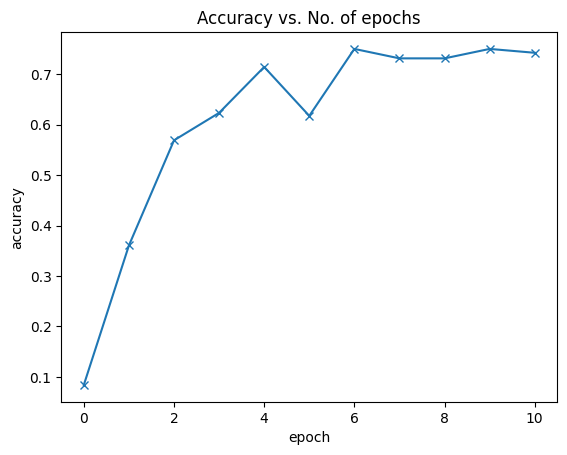

In [24]:
plot_acc(history)

## Testing the model

In [25]:
test_dl = DataLoader(test_ds,batch_size=8)
test_dl

In [26]:
for batch in test_dl:
    images, labels = batch
    images,labels = images.cuda(),labels.cuda()
    print('images.shape: ',images.shape)
    print(images.device)
    preds = model(images)
    print('preds.shape: ',preds.shape)
    print(preds)
    break

images.shape:  torch.Size([8, 3, 224, 224])
cuda:0
preds.shape:  torch.Size([8, 8])
tensor([[ 5.3111, -2.0795, -0.5006, -2.3449,  1.0573, -2.2603,  0.2815, -1.2268],
        [ 3.1561, -4.2221, -1.8274, -0.6816, -0.5745,  3.7441, -5.1014, -1.2164],
        [ 7.4257, -0.0501,  0.2484,  0.9116, -1.4699, -3.1109, -1.2697, -1.2446],
        [-1.9265, -1.0452, -0.1065, -1.2136,  1.4007, -2.8492,  1.1189,  4.4763],
        [ 0.9667, -1.3480,  0.2977, -1.1727, -0.7010,  3.6415, -0.8722, -0.5883],
        [-3.9311,  0.3683, -3.3388,  0.9794,  3.1343,  4.8115, -4.3667, -1.5314],
        [-2.5276, -3.2395,  0.6619, -1.2612,  6.9909,  2.9636, -3.7198, -3.0921],
        [ 3.0587, -0.3530, -1.0107, -2.6882,  0.8762, -1.1111, -0.3655, -2.1988]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


## Calculating AUC score 

In [27]:
metric1 = MulticlassAUROC(num_classes=8)
metric1.update(preds, labels)
metric1.compute()

tensor(0.7042)

## Calculating the F1 Score

In [28]:
predictions = torch.stack([torch.argmax(pred) for pred in preds]).to('cpu')
predictions

tensor([0, 5, 0, 7, 5, 5, 4, 0])

In [29]:
metric2 = MulticlassF1Score(num_classes=8)
metric2.update(predictions, labels)
metric2.compute()

tensor(0.6250)